In [ ]:
##make sure the latest version is installed. 0.1.80 and restart the kernel
!pip install --upgrade azureml-sdk[notebooks,contrib]

In [ ]:
!pip install scikit-image

In [ ]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

# Dog breed classification using Pytorch Estimators on Azure Machine Learning service

Have you ever seen a dog and not been able to tell the breed? Some dogs look so similar, that it can be nearly impossible to tell. For instance these are a few breeds that are difficult to tell apart:

#### Alaskan Malamutes vs Siberian Huskies
![Image of Alaskan Malamute vs Siberian Husky](http://cdn.akc.org/content/article-body-image/malamutehusky.jpg)

#### Whippet vs Italian Greyhound 
![Image of Whippet vs Italian Greyhound](http://cdn.akc.org/content/article-body-image/whippetitalian.jpg)

There are sites like http://what-dog.net, which use Microsoft Cognitive Services to be able to make this easier. 

In this tutorial, you will learn how to train your own image classification model using transfer learning. The Azure Machine Learning python SDK's [PyTorch estimator](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-train-pytorch) enables you to easily submit PyTorch training jobs for both single-node and distributed runs on Azure compute. The model is trained to classify dog breeds using a pretrained ResNet18 model that has been trained on the [Stanford Dog dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. For time, we will use a subset of this dataset which includes 10 dog breeds.

## What is Azure Machine Learning service?
Azure Machine Learning service (Preview) is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.
![](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/overview-what-is-azure-ml/aml.png)


## How can we use it for training image classification models?
Training machine learning models, particularly deep neural networks, is often a time- and compute-intensive task. Once you've finished writing your training script and running on a small subset of data on your local machine, you will likely want to scale up your workload.

To facilitate training, the Azure Machine Learning Python SDK provides a high-level abstraction, the estimator class, which allows users to easily train their models in the Azure ecosystem. You can create and use an Estimator object to submit any training code you want to run on remote compute, whether it's a single-node run or distributed training across a GPU cluster. For PyTorch and TensorFlow jobs, Azure Machine Learning also provides respective custom PyTorch and TensorFlow estimators to simplify using these frameworks.

### Steps to train with a Pytorch Estimator:
In this tutorial, we will:
- Connect to an Azure Machine Learning service Workspace 
- Create a remote compute target
- Upload your training data (Optional)
- Create your training script
- Create an Estimator object
- Submit your training job

## Prerequisites
* Sign up for an [Azure account](https://azure.microsoft.com/en-ca/free/search)
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
![](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/concept-azure-machine-learning-architecture/workflow.png)

## Setup

### Azure IDs used for this workshop (needs to be updated)
```
subscription_id='4feb84f6-2c10-4536-9c8a-0a2360eabfc5'
resource_group='azureml'
container_registry='/subscriptions/4feb84f6-2c10-4536-9c8a-0a2360eabfc5/resourcegroups/azureml/providers/microsoft.containerregistry/registries/danielscacrcvsldmti'
location='westeurope'
```

### Conda/Miniconda
[Download](https://conda.io/miniconda.html) and install Miniconda. Select the Python 3.7 version or later. Don't select the Python 2.x version.

### AzureML Python SDK
Install the Python SDK:  make sure to install notebook, and contrib
```
conda create -n azureml -y Python=3.6
source activate azureml
pip install --upgrade azureml-sdk[notebooks,contrib] --user
jupyter nbextension install --py --user azureml.widgets
jupyter nbextension enable azureml.widgets --user --py
```
You will need to restart jupyter after this
Detailed instructions are here: https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-create-workspace-with-python 

### (Optional) Install VS Code and the VS Code extension 
[Download](https://code.visualstudio.com/) and install Visual Studio Code then the [Azure Machine Learning Extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.vscode-ai)
Make sure it has a recent version of the Python SDK -- remove the folder ~/.azureml/envs if there are issuse. A current SDK will be installed when you first use AML from VSCode.

### Clone this repository
```
git clone https://github.com/danielsc/dogbreeds
jupyter notebook
```

## Create workspace
We will provide a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object to use in this tutorial. If you want to use a different subscription, you can enter the information below and create a Workspace. This step checks to see if the workspace is created and writes a `config.json` that can be used to reference the workspace in other notebooks. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

**You will be asked to login during this step. Please use the AAD credentials provided to you.**

In [ ]:
from azureml.core.workspace import Workspace

subscription_id = "4feb84f6-2c10-4536-9c8a-0a2360eabfc5"
resource_group = "dogbreed-workshop"
workspace_name = "DanielSc" ## or use "pycon-canada-2"
workspace_region = "westeurope"

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      container_registry = container_registry,
                      create_resource_group = True,
                      exist_ok = True)
ws.write_config()

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

## Create a remote compute target
For this tutorial, we already have a  [Azure Batch AI](https://docs.microsoft.com/azure/batch-ai/overview) cluster with a NC6s_v2, P100 GPU machine, created to use as the [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) to execute your training script on. 

This code creates a cluster for you if it does not already exist in your workspace.

**Creation of the cluster takes approximately 5 minutes.** If the cluster is already in your workspace this code will skip the cluster creation process.

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "p100cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6s_v2', 
                                                            autoscale_enabled=True,
                                                            min_nodes=1, 
                                                            max_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

    # Use the 'status' property to get a detailed status for the current cluster. 
    print(compute_target.status.serialize())

## Attach the blobstore with the training data to the workspace
The dataset we will use consists of ~150 images per class. Some breeds have more, while others have less. Each class has about 100 training images each for dog breeds, with ~50 validation images for each class. We will look at 10 classes in this tutorial.

To make the data accessible for remote training, you will need to keep the data in the cloud. AML provides a convenient way to do so via a [Datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage. The datastore can reference either an Azure Blob container or Azure file share as the underlying storage. 

You can view the subset of the data used [here](https://github.com/heatherbshapiro/pycon-canada/tree/master/breeds-10). Or download it from [here](https://github.com/heatherbshapiro/pycon-canada/master/breeds-10.zip) as a zip file. **If you already have the breeds datstore attached you can skip the following code and access it through the following code:**

`ds= ws.datastores["breeds"]`

We already copied the data to an Azure blob storage container. To attach this blob container as a data store to your workspace, you use the `Datastore.register_azure_blob_container` function. You can copy the statement with the secrets filled in from [here](https://microsoft.sharepoint.com/teams/azuremlnursery/_layouts/OneNote.aspx?id=%2Fteams%2Fazuremlnursery%2FSiteAssets%2FAzure%20ML%20Nursery%20Notebook&wd=target%28Workshop.one%7C265D85D5-44C8-9D40-B556-A31FA098E708%2FDogbreeds%7C62F09F92-105C-7849-AF84-905BEE9F9588%2F%29) (requires Microsoft Employee login).




In [ ]:
from azureml.core import Datastore
ds = Datastore.register_azure_blob_container(workspace=ws, 
                                             datastore_name='breeds', 
                                             container_name=<<add container name>>,
                                             account_name=<<add account name name>>, 
                                             account_key=<<add account key ending with ==>>)

Now let's get a reference to the path on the datastore with the training data. We can do so using the `path` method. In the next section, we can then pass this reference to our training script's `--data_dir` argument. We will start with the 10 classes dataset.

In [ ]:
path_on_datastore = 'breeds-10'
ds_data = ds.path(path_on_datastore)
print(ds_data)

## Download the Data

If you are interested in downloading the data locally, you can run `ds.download(".", 'breeds-10')`. This might take several minutes.

In [ ]:
ds.download('.', 'breeds-10', show_progress=True)

### Prepare training script
Now you will need to create your training script. In this tutorial, the training script is already provided for you at `pytorch_train.py`. In practice, you should be able to take any custom training script as is and run it with AML without having to modify your code.

However, if you would like to use AML's [tracking and metrics](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#metrics) capabilities, you will have to add a small amount of AML code inside your training script. 

In `pytorch_train.py`, we will log some metrics to our AML run. To do so, we will access the AML run object within the script:
```Python
from azureml.core.run import Run
run = Run.get_context()
```
Further within `pytorch_train.py`, we log the learning rate and momentum parameters, the best validation accuracy the model achieves, and the number of classes in the model:
```Python
run.log('lr', np.float(learning_rate))
run.log('momentum', np.float(momentum))
run.log('num_classes', num_classes)

run.log('best_val_acc', np.float(best_acc))
```

If you downloaded the data, you can start to train the model locally (note that it will take long if you don't have a GPU -- 21 min. on a Core i7 CPU).



In [ ]:
!mkdir -p outputs
!python pytorch_train.py --data_dir breeds-10 --num_epochs 10 --output_dir outputs 

## Train model on the remote compute
Now that you have your data and training script prepared, you are ready to train on your remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time. 

### Create an experiment
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) to track all the runs in your workspace for this transfer learning PyTorch tutorial. 

**Please enter your own unique name so that you can track your specific runs.**

In [ ]:
from azureml.core import Experiment

experiment_name = 'pytorch-dogs-ds' ## An example would be "pytorch-dogs-hs"
experiment = Experiment(ws, name=experiment_name)

### Create a PyTorch estimator
The AML SDK's PyTorch estimator enables you to easily submit PyTorch training jobs for both single-node and distributed runs. For more information on the PyTorch estimator, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-train-pytorch). The following code will define a single-node PyTorch job.

In [125]:
##BATCH AI
from azureml.train.dnn import PyTorch

script_params = {
    '--data_dir': ds_data.as_mount(),
    '--num_epochs': 10,
    '--output_dir': './outputs',
    '--mode': 'fine_tune'
}

estimator10 = PyTorch(source_directory='.', 
                    script_params=script_params,
                    compute_target=compute_target, 
                    entry_script='pytorch_train.py',
                    use_gpu=True)


The `script_params` parameter is a dictionary containing the command-line arguments to your training script `entry_script`. Please note the following:
- We passed our training data reference `ds_data` to our script's `--data_dir` argument. This will 1) mount our datastore on the remote compute and 2) provide the path to the training data `breeds` on our datastore.
- We specified the output directory as `./outputs`. The `outputs` directory is specially treated by AML in that all the content in this directory gets uploaded to your workspace as part of your run history. The files written to this directory are therefore accessible even once your remote run is over. In this tutorial, we will save our trained model to this output directory.

To leverage the Azure VM's GPU for training, we set `use_gpu=True`.

### Submit job
Run your experiment by submitting your estimator object. Note that this call is asynchronous.

In [126]:
run10 = experiment.submit(estimator10)

### Monitor your run
You can monitor the progress of the run with a Jupyter widget. Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [127]:
from azureml.widgets import RunDetails
RunDetails(run10).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

### Using Tensorboard (todo)

### Distributed training (todo)

Now that the setup is working, we can go to the full dataset with 120 classes. We just need to point to a different path on the datastore. 

In [135]:
full_dataset = ds.path('breeds')
print(full_dataset)

$AZUREML_DATAREFERENCE_fb2c142048fb42659b26b30a6ddfd964


In [136]:
## AML Compute
from azureml.train.dnn import PyTorch

script_params = {
    '--data_dir': full_dataset.as_mount(),
    '--num_epochs': 25,
    '--output_dir': './outputs',
    '--mode': 'fine_tune'
}

estimator120 = PyTorch(source_directory='.', 
                        script_params=script_params,
                        compute_target=compute_target, 
                        entry_script='pytorch_train.py',
                        use_gpu=True)

run120 = experiment.submit(estimator120)

from azureml.widgets import RunDetails
RunDetails(run120).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

But now training takes very long (1.5 hours), so let's see if we can run this job on multiple GPUs to cut down on training time.

In [137]:
# first let's cancel the above job
run120.cancel()

Running the model on multiple nodes is simple (in this case using MPI via Horovod running on 4 nodes)

### Hyperparameter Tuning

In [132]:

from azureml.train.hyperdrive import *

ps = RandomParameterSampling(
    {
        '--momentum': uniform(0.6,0.99),
        '--learning_rate': loguniform(-6, -1)
    }
)

policy = BanditPolicy(evaluation_interval=2, slack_factor=0.2)


hdc = HyperDriveRunConfig(estimator=estimator10, 
                          hyperparameter_sampling=ps, 
                          policy=policy, 
                          primary_metric_name='best_val_acc', 
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=10,
                          max_concurrent_runs=4)

hd_run = experiment.submit(hdc)
RunDetails(hd_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO',…

In [133]:
hd_run.get_metrics()

{'pytorch-dogs-ds_1543381912984_0': {'mode': ['fine_tune'],
  'lr': [0.0174718434808327],
  'momentum': [0.644319899109752],
  'num_classes': [10],
  'best_val_acc': [0,
   0.09836065573770492,
   0.09836065573770492,
   0.15052160953800298,
   0.15052160953800298,
   0.16840536512667661,
   0.16840536512667661,
   0.16840536512667661,
   0.16840536512667661,
   0.20566318926974664,
   0.20566318926974664,
   0.22503725782414308,
   0.22503725782414308,
   0.22503725782414308,
   0.22503725782414308,
   0.28763040238450077,
   0.28763040238450077,
   0.28912071535022354,
   0.28912071535022354,
   0.31296572280178836]},
 'pytorch-dogs-ds_1543381912984_1': {'mode': ['fine_tune'],
  'lr': [0.329829404265382],
  'momentum': [0.92936118395922],
  'num_classes': [10],
  'best_val_acc': [0,
   0.07451564828614009,
   0.07451564828614009,
   0.07451564828614009,
   0.07451564828614009,
   0.08494783904619971,
   0.08494783904619971,
   0.08494783904619971,
   0.08494783904619971,
   0.1236959

### Create scoring script

First, we will create a scoring script that will be invoked by the web service call. Note that the scoring script must have two required functions:
* `init()`: In this function, you typically load the model into a `global` object. This function is executed only once when the Docker container is started. 
* `run(input_data)`: In this function, the model is used to predict a value based on the input data. The input and output typically use JSON as serialization and deserialization format, but you are not limited to that.

Refer to the scoring script `pytorch_score.py` for this tutorial. Our web service will use this file to predict the dog breed based on a 120 class model trained earlier, located in the folder `model`. We will test the scoring file locally first before you go and deploy the web service.

1. Import the scoring script, so that init() and run() are accessible

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pytorch_score

2. Call the init function -- this will load the model and the class_names from the model directory

In [ ]:
pytorch_score.init()

3. Add some helper functions:

In [ ]:
import os, json, base64
from io import BytesIO
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import urllib.request
import io

##Get random dog
def get_random_dog():
    r = requests.get(url ="https://dog.ceo/api/breeds/image/random")
    URL= r.json()['message']
    return URL

def imgToBase64(img):
    """Convert pillow image to base64-encoded image"""
    imgio = BytesIO()
    img.save(imgio, 'JPEG')
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

4. Find an image of a dog and call the run() function

In [ ]:
##Get Random Dog Image
URL = get_random_dog()

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())


plt.imshow(Image.open(test_img))

base64Img = imgToBase64(Image.open(test_img))

result = pytorch_score.run(input_data=json.dumps({'data': base64Img}))
print(URL)
print(json.loads(result))

### Register the model
Once the run completes, we can register the model that was created.

**Please use a unique name for the model**

In [ ]:
from azureml.core.model import Model
model = Model.register(ws, model_name='model', model_path = 'model', description='120 Dogbreeds')
print(model.name, model.id, model.version, sep = '\t')

## Deploy model as web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances (ACI), Azure Kubernetes Service (AKS), IoT edge device, or field programmable gate arrays (FPGAs)

ACI is generally cheaper than AKS and can be set up in 4-6 lines of code. ACI is the perfect option for testing deployments. Later, when you're ready to use your models and web services for high-scale, production usage, you can deploy them to AKS.


In this tutorial, we will deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/) (ACI). 


For more information on deploying models using Azure ML, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).

### Create environment file
Then, we will need to create an environment file (`myenv.yml`) that specifies all of the scoring script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image by AML. In this case, we need to specify `torch`, `torchvision`, `pillow`, and `azureml-sdk`.

In [ ]:
%%writefile myenv.yml
name: myenv
channels:
  - defaults
dependencies:
  - pip:
    - torch
    - torchvision
    - pillow
    - azureml-core

### Configure the container image
Now configure the Docker image that you will use to build your ACI container.

In [ ]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script='pytorch_score.py', 
                                                  runtime='python', 
                                                  conda_file='myenv.yml',
                                                  description='Image with dog breed model')

### Configure the ACI container
We are almost ready to deploy. Create a deployment configuration file to specify the number of CPUs and gigabytes of RAM needed for your ACI container. While it depends on your model, the default of `1` core and `1` gigabyte of RAM is usually sufficient for many models.

In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'dog_breeds',  'method':'transfer learning', 'framework':'pytorch'},
                                               description='Classify dog breeds using transfer learning with PyTorch')

### Deploy the registered model
Finally, let's deploy a web service from our registered model. First, retrieve the model from your workspace.

In [ ]:
from azureml.core.model import Model

model = ws.models['model']

Then, deploy the web service using the ACI config and image config files created in the previous steps. We pass the `model` object in a list to the `models` parameter. If you would like to deploy more than one registered model, append the additional models to this list.

** Please use a unique service name**

In [116]:
%%time
from azureml.core.webservice import Webservice

service_name = 'dog120'
service = Webservice.deploy_from_model(workspace=ws,
                                       name=service_name,
                                       models=[model],
                                       image_config=image_config,
                                       deployment_config=aciconfig,)

service.wait_for_deployment(show_output=True)
print(service.state)

Image creation operation finished for image dog120:1, operation "Succeeded"
Creating service
Running.......................................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 8.94 s, sys: 1.12 s, total: 10.1 s
Wall time: 9min 49s


If your deployment fails for any reason and you need to redeploy, make sure to delete the service before you do so: `service.delete()`

**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [ ]:
service.get_logs()


Get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [118]:
print(service.scoring_uri)

http://51.144.33.173:80/score


### Test the web service
Finally, let's test our deployed web service. We will send the data as a JSON string to the web service hosted in ACI and use the SDK's `run` API to invoke the service. Here we will take an arbitrary image from online to predict on. This is the same as above, but now we are testing on our own trained model. You can use any dog image, but please remember we only trained on 10 classes.

https://images.dog.ceo/breeds/germanshepherd/n02106662_7122.jpg


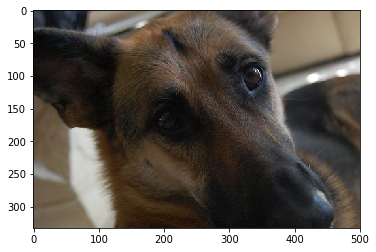

In [122]:
##Get Random Dog Image
URL = get_random_dog()

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

plt.imshow(Image.open(test_img))

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

plt.imshow(Image.open(test_img))
print(URL)

In [123]:
def imgToBase64(img):
    """Convert pillow image to base64-encoded image"""
    imgio = BytesIO()
    img.save(imgio, 'JPEG')
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

base64Img = imgToBase64(Image.open(test_img))

result = service.run(input_data=json.dumps({'data': base64Img}))
print(json.loads(result))

{'probability': '0.77051634', 'label': 'n02106662-German_shepherd'}


### Delete web service
Once you no longer need the web service, you should delete it.

In [ ]:
service.delete()